In [1]:
import os
import os.path as op
import sys

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

#from bluemath_tk.wrappers.swash.swash_wrapper import SwashModelWrapper
from IPython.display import HTML

from scripts.wrappers import SwashModelWrapper_shoaling

from scripts.bathymetry import linear_profile
from scripts.plots import plot_case_config

#### Inputs

In [2]:
templates_dir = '/workspaces/ONDAS_Swash/templates/templates_shoaling'
output_dir = '/workspaces/ONDAS_Swash/cases/shoaling'

In [3]:
Hs = 2.5
Tp = 10
Hs_L0 =  round((2 * np.pi * (Hs)) / (9.81 * (Tp ** 2)),4)  # Should be between 0.005 and 0.05
WL = 0.0

In [4]:
Hs_L0

0.016

In [5]:
h0 = -12  # offshore depth (m)
Ltotal = 1000  # beach heigh (m)
m = 8 / 300  # profile slope
Wfore = 400  # flume length before fore toe (m)

x_profile, depth_array = linear_profile(h0=h0, Ltotal=Ltotal, Wconst=Wfore, slope=m)

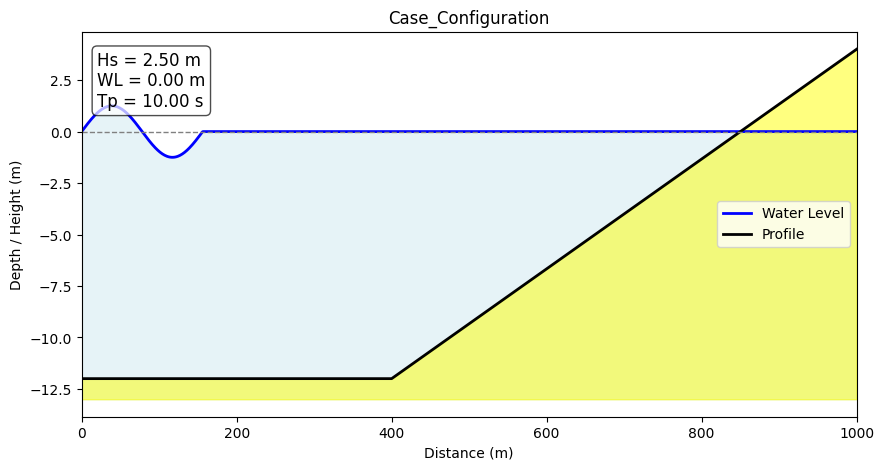

In [6]:
plot_case_config(x=x_profile, z=depth_array, wave_height=Hs, wave_period = Tp, WL=WL)

In [7]:
params = pd.DataFrame()
params['factor'] = np.arange(8,21,1) # Vector de 8 a 20 de 1 en 1

params['m'] = params['factor'] / 300
params['Ltotal'] = 1000
params['h0'] = -12
params['Wfore'] = 400

params['Hs'] = Hs
params['Hs_L0'] = Hs_L0 
params['WL'] = WL

In [8]:
metamodel_parameters = params.to_dict(orient='list')

fixed_parameters = {
    "dxinp": 1,  # bathymetry grid spacing  # Friction manning coefficient (m^-1/3 s)
    "comptime": 300,  # Simulation duration (s)
    "warmup": 300,  # Warmup duration (s)
    "n_nodes_per_wavelength": 60,  # number of nodes per wavelength
}

swash_model = SwashModelWrapper_shoaling(
    templates_dir=templates_dir,
    metamodel_parameters=metamodel_parameters,
    fixed_parameters=fixed_parameters,
    output_dir=output_dir,
    depth_array=-depth_array,
)

2025-10-26 13:21:27,318 - SwashModelWrapper_shoaling - WARNING - Parameter factor is not in the default_parameters
2025-10-26 13:21:27,319 - SwashModelWrapper_shoaling - WARNING - Parameter m is not in the default_parameters
2025-10-26 13:21:27,319 - SwashModelWrapper_shoaling - WARNING - Parameter Ltotal is not in the default_parameters
2025-10-26 13:21:27,320 - SwashModelWrapper_shoaling - WARNING - Parameter h0 is not in the default_parameters
2025-10-26 13:21:27,321 - SwashModelWrapper_shoaling - WARNING - Parameter Wfore is not in the default_parameters


In [9]:
swash_model.build_cases()

In [10]:
swash_model.run_cases(launcher='serial')

In [11]:
vars_to_postprocess = ["Msetup", "Hrms", "Hfreqs"]
postprocessed = swash_model.postprocess_cases(output_vars=vars_to_postprocess)

In [12]:
postprocessed

<xarray.Dataset> Size: 633kB
Dimensions:   (case_num: 13, Xp: 1001)
Coordinates:
  * case_num  (case_num) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * Xp        (Xp) int64 8kB 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
    Yp        int64 8B 0
Data variables:
    Msetup    (case_num, Xp) float64 104kB 0.03162 0.02827 ... 27.93 27.98
    Hrms      (case_num, Xp) float64 104kB 1.838 1.819 ... 1.005e-14 1.005e-14
    Hs        (case_num, Xp) float64 104kB 2.653 2.627 ... 1.297e-14 2.595e-14
    Hss       (case_num, Xp) float64 104kB 2.619 2.592 ... 4.706e-18 9.412e-18
    ig        (case_num, Xp) float64 104kB 0.4265 0.4272 ... 1.297e-14 2.595e-14
    Hvlf      (case_num, Xp) float64 104kB 0.1451 0.1455 ... 1.214e-14 2.429e-14

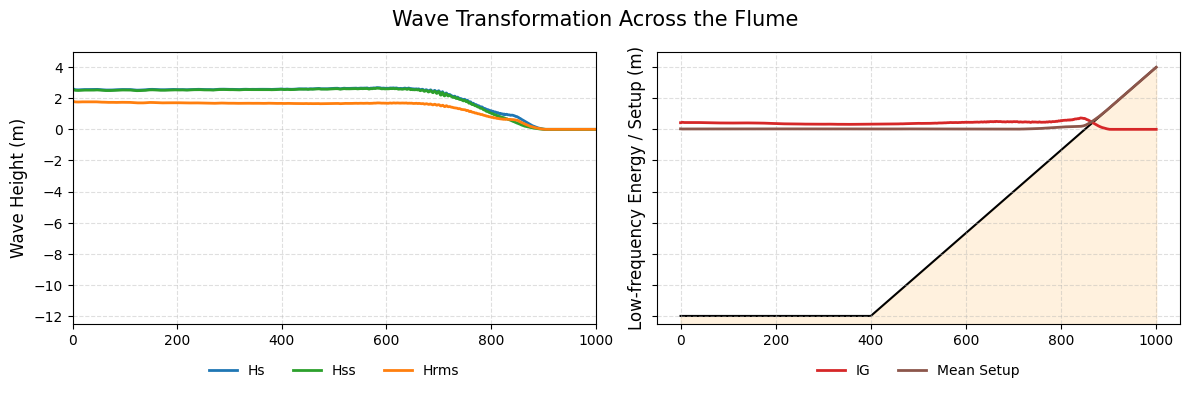

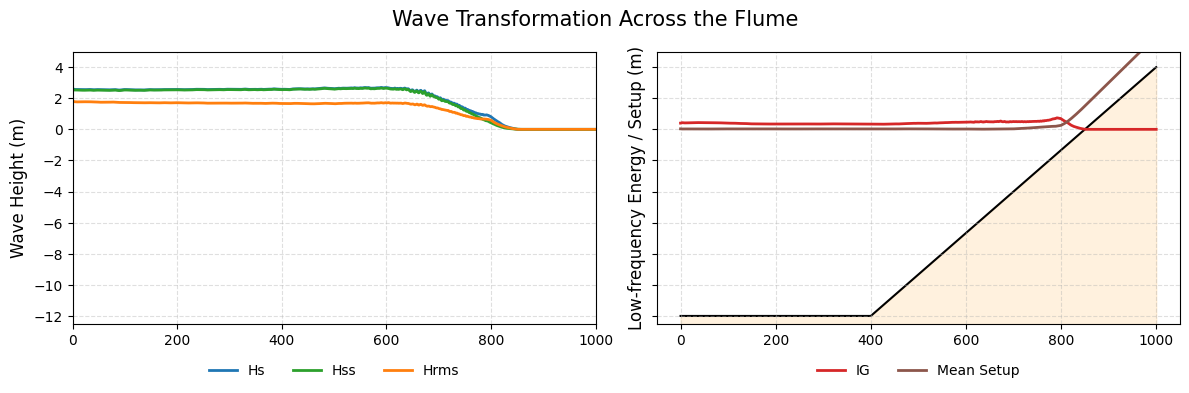

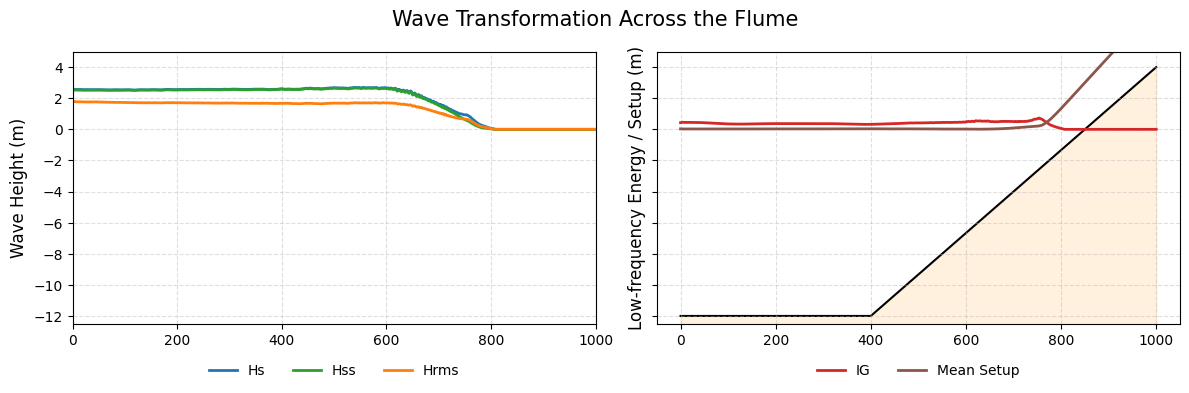

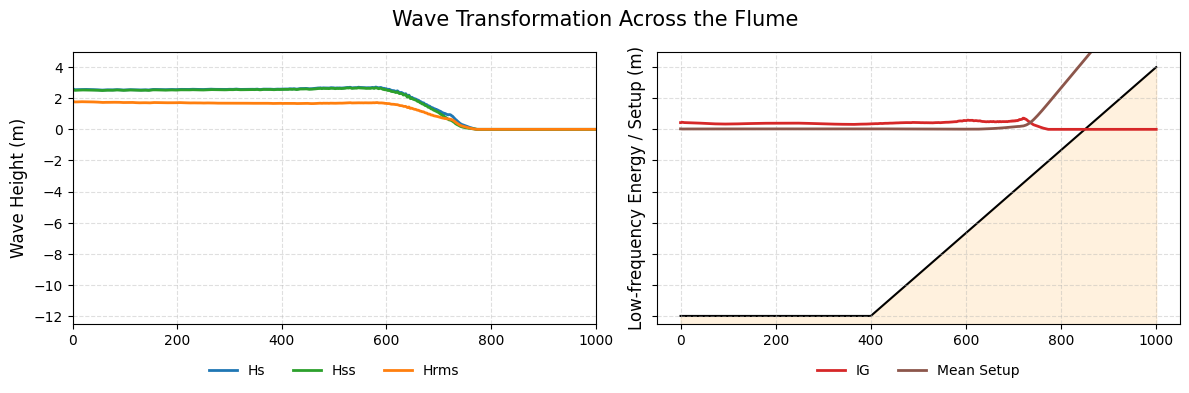

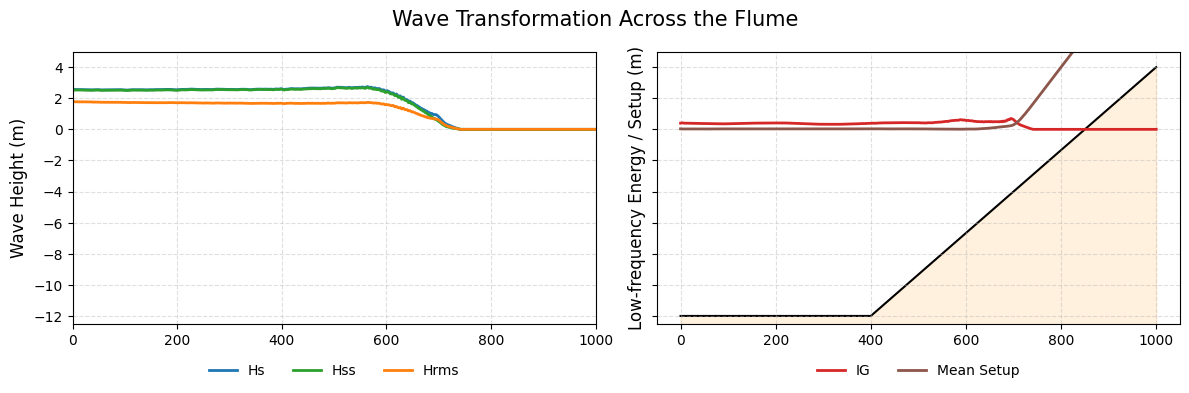

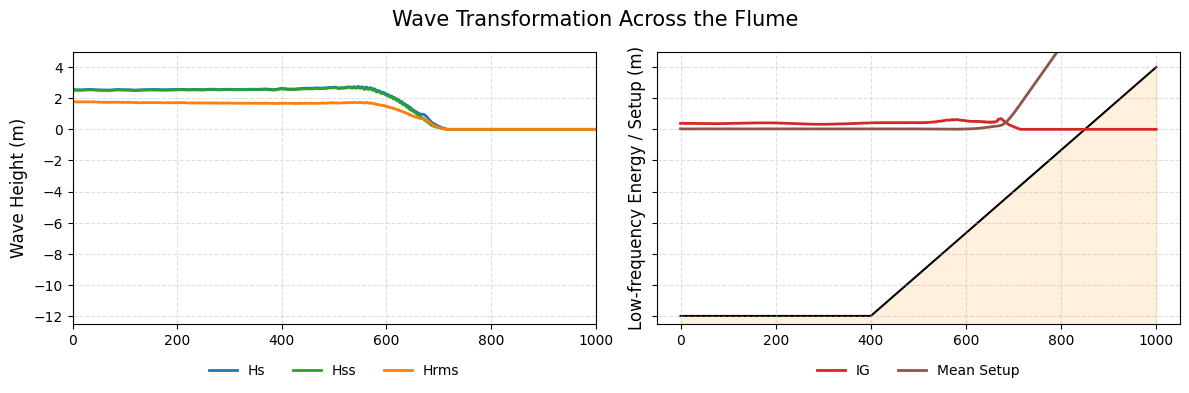

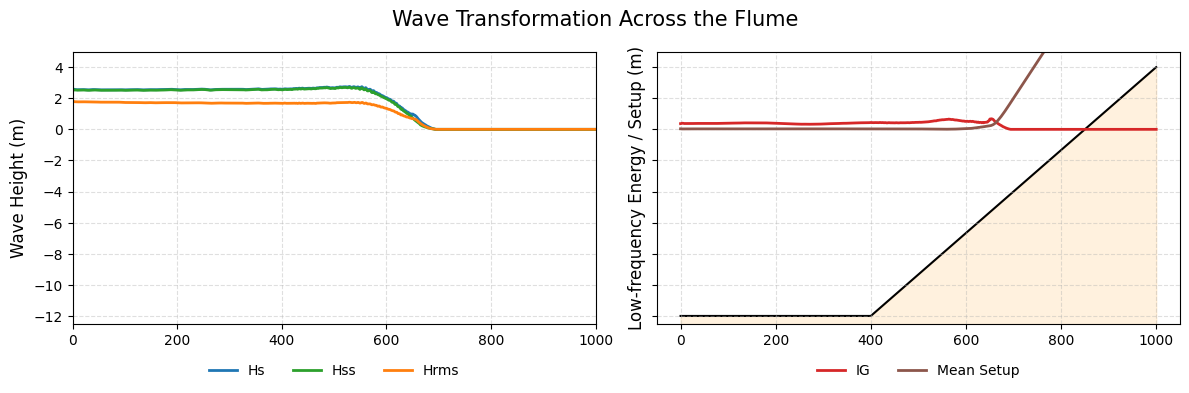

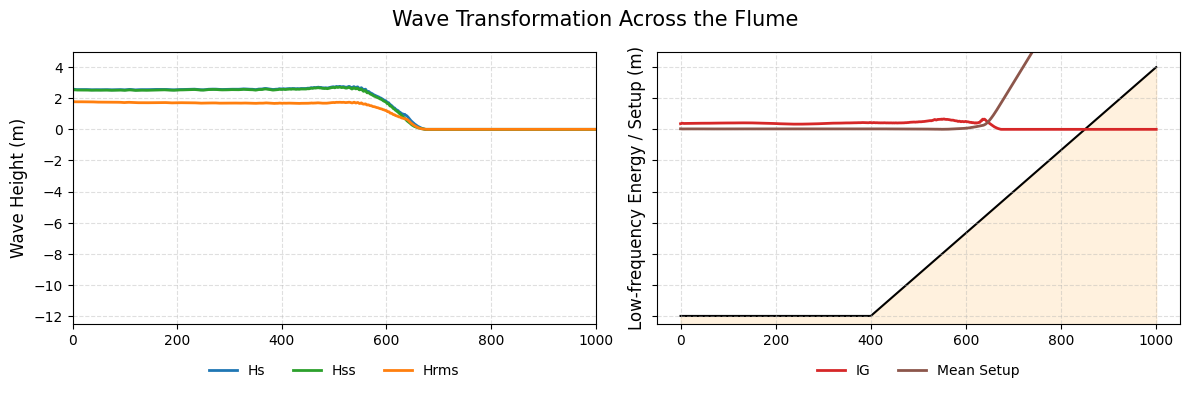

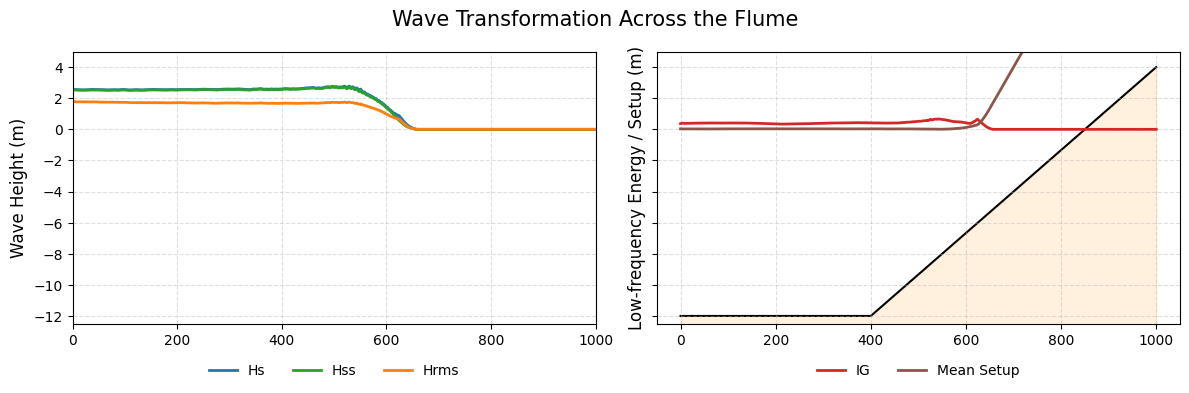

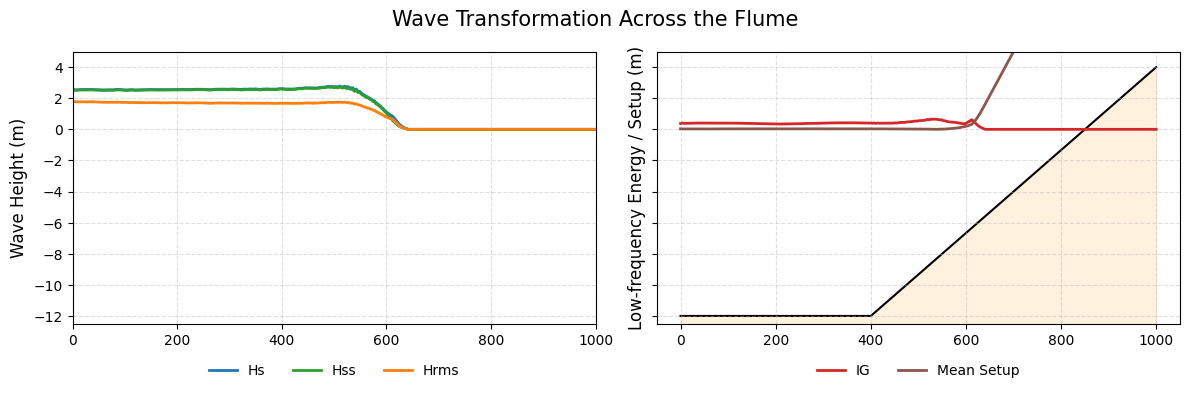

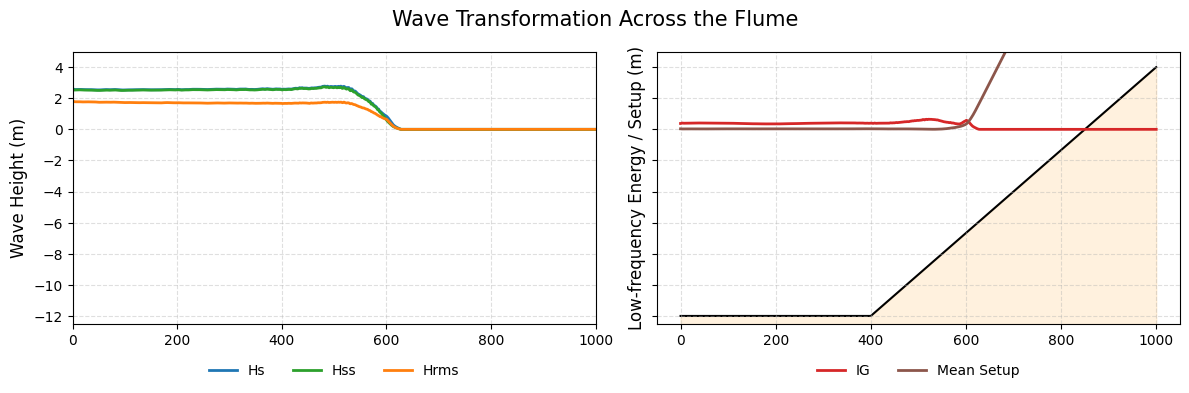

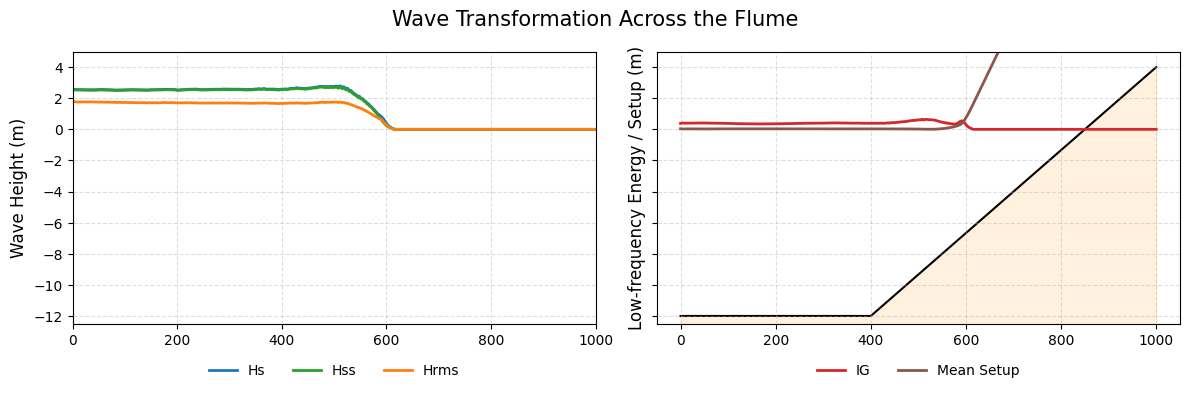

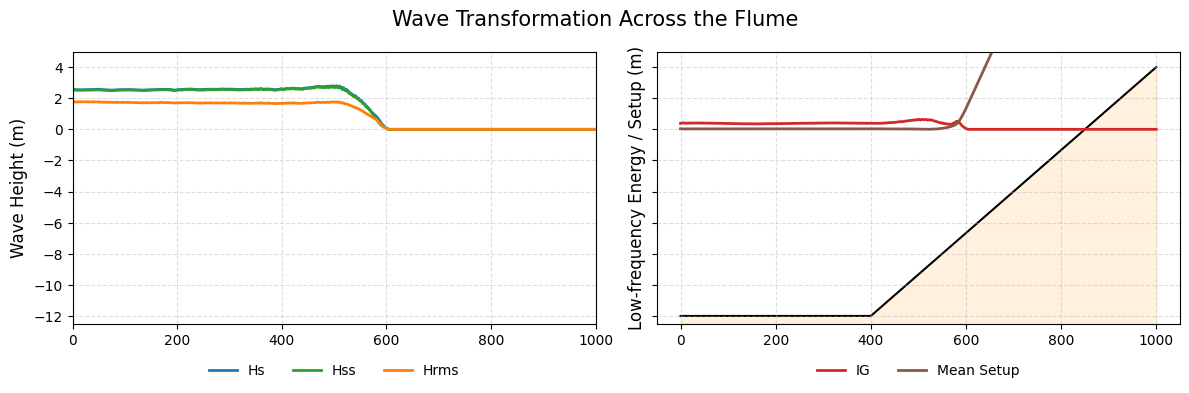

In [14]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(len(postprocessed.case_num.values)):
    post_process_case = postprocessed.isel(case_num=i)

    fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)

    ax1 = axs[0]
    ax1.plot(post_process_case.Xp, post_process_case.Hs, label='Hs', color='tab:blue', lw=2)
    ax1.plot(post_process_case.Xp, post_process_case.Hss, label='Hss', color='tab:green', lw=2)
    ax1.plot(post_process_case.Xp, post_process_case.Hrms, label='Hrms', color='tab:orange', lw=2)

    '''ax1.fill_between(np.arange(0, len(depth_array)), depth_array, np.min(depth_array)-1,
                    color='navajowhite', alpha=0.4, zorder=0)
    ax1.plot(np.arange(0, len(depth_array)), depth_array, color='k', lw=1.5, zorder=1)'''

    ax1.set_ylabel('Wave Height (m)', fontsize=12)
    ax1.grid(True, ls='--', alpha=0.4)
    ax1.legend(loc='upper right', fontsize=10, ncol=2, frameon=True)

    ax2 = axs[1]
    ax2.plot(post_process_case.Xp, post_process_case.ig, label='IG', color='tab:red', lw=2)
    ax2.plot(post_process_case.Xp, post_process_case.Msetup, label='Mean Setup', color='tab:brown', lw=2)

    ax2.fill_between(np.arange(0, len(depth_array)), depth_array, np.min(depth_array)-1,
                    color='navajowhite', alpha=0.4, zorder=0)
    ax2.plot(np.arange(0, len(depth_array)), depth_array, color='k', lw=1.5, zorder=1)

    ax2.set_ylabel('Low-frequency Energy / Setup (m)', fontsize=12)
    ax2.grid(True, ls='--', alpha=0.4)
    ax2.legend(loc='upper right', fontsize=10, ncol=2, frameon=True)

    axs[0].set_xlim([np.min(postprocessed.Xp), np.max(postprocessed.Xp)])
    axs[0].set_ylim([-12.5, 5])
    axs[1].set_ylim([-12.5, 5])
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
            ncol=3, fontsize=10, frameon=False)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
            ncol=2, fontsize=10, frameon=False)

    fig.suptitle('Wave Transformation Across the Flume', fontsize=15)

    plt.tight_layout()
    plt.show()
